In [5]:
from dotenv import load_dotenv

load_dotenv()

True

# 0) 그래프 State 정의

In [6]:
from typing import TypedDict, Annotated, List, Dict
import operator
from langchain_core.documents import Document


class GraphState(TypedDict):
    filepath: Annotated[str, "filepath"]  # 원본 파일 경로
    
    analyzed_files : Annotated[List, "analyzed_files"]

    metadata: Annotated[List[Dict], operator.add]  # parsing metadata (api, model, usage)
    
    elements_from_parser: Annotated[List[Dict], "elements_from_parser"]  


In [7]:
state = GraphState(filepath='C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/samsung')
state

{'filepath': 'C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/samsung'}

# 1) PDF split

- 몇 페이지씩 자를 것인가?
- upstage는 한번에 100페에지까지만 처리 가능
- 논문이 짧아서 굳이 안잘라도 될듯

In [ ]:
import pymupdf
import os

def split_pdf_by_batch(file_path, batch_size):
    # PDF 파일 열기
    input_pdf = pymupdf.open(file_path)
    num_pages = len(input_pdf)
    print(f"총 페이지 수: {num_pages}")

    # 출력 디렉토리: 원본 파일이 있는 디렉토리 내의 "split_docs" 폴더 생성
    output_dir = os.path.join(os.path.dirname(file_path), "split_docs")
    os.makedirs(output_dir, exist_ok=True)

    ret = []
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    # PDF 분할: batch_size 만큼의 페이지씩 분할
    for start_page in range(0, num_pages, batch_size):
        end_page = min(start_page + batch_size, num_pages) - 1
        output_file = os.path.join(output_dir, f"{base_name}_{start_page:04d}_{end_page:04d}.pdf")
        print(f"분할 PDF 생성: {output_file}")
        
        with pymupdf.open() as output_pdf:
            output_pdf.insert_pdf(input_pdf, from_page=start_page, to_page=end_page)
            output_pdf.save(output_file)
        ret.append(output_file)

    input_pdf.close()
    return ret

split_pdf_by_batch(file_path="C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/1-s2.0-S0952818016300204-main.pdf",
                   batch_size=6)

# 2) Upstage Document parser 이용해 layout 분석

In [8]:
import requests
import json
import os

DEFAULT_CONFIG = {
    "ocr": False,
    "coordinates": True,
    "output_formats": "['html', 'text', 'markdown']",
    "model": "document-parse",
    "base64_encoding": "['figure', 'chart', 'table']",
}

def analyze_layout(state: GraphState):
    """
    분할된 PDF 파일들을 Upstage API로 전송하여 레이아웃 분석을 수행하고,
    결과 JSON 파일들을 저장하는 함수.

    Returns:
    - list: 성공적으로 분석된 파일들의 결과 JSON 파일 경로 목록.
    """
    docs_folder = state['filepath']

    output_folder = os.path.join(docs_folder, "analysis_results")
    os.makedirs(output_folder, exist_ok=True)
    
    api_url = "https://api.upstage.ai/v1/document-ai/document-parse"
    api_key = os.environ.get("UPSTAGE_API_KEY")
    # split_docs 폴더 내의 모든 PDF 파일 가져오기
    pdf_files = [f for f in os.listdir(docs_folder) if f.endswith(".pdf")]
    output_paths = []
    metadata_list = []
    
    for pdf_file in pdf_files:
        file_path = os.path.join(docs_folder, pdf_file)
        output_json_path = os.path.join(output_folder, f"{os.path.splitext(pdf_file)[0]}.json")
        print(f"📤 파일 업로드 중: {pdf_file}")
        
        with open(file_path, "rb") as pdf:
            response = requests.post(
                api_url,
                headers={"Authorization": f"Bearer {api_key}"},
                data=DEFAULT_CONFIG,
                files={"document": pdf}
            )
        
        # 응답 확인 및 JSON 파일 저장
        if response.status_code == 200:
            result = response.json()
            with open(output_json_path, "w", encoding="utf-8") as json_file:
                json.dump(result, json_file, ensure_ascii=False, indent=4)
            print(f"✅ 분석 결과 저장 완료: {output_json_path}")
            output_paths.append(output_json_path)
            meta = {
                "id": pdf_file,
                "model": result.get("model"),
                "usage": result.get("usage")
            }
            metadata_list.append(meta)
        else:
            print(f"❌ 오류 발생 ({response.status_code}): {response.text}")
    
    print("🎉 모든 파일 분석 완료!")
    return GraphState(metadata=metadata_list,
                      analyzed_files=output_paths)

In [9]:
state_out = analyze_layout(state)
state.update(state_out)
state

📤 파일 업로드 중: samsung.pdf
✅ 분석 결과 저장 완료: C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/samsung\analysis_results\samsung.json
🎉 모든 파일 분석 완료!


{'filepath': 'C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/samsung',
 'metadata': [{'id': 'samsung.pdf',
   'model': 'document-parse-250116',
   'usage': {'pages': 53}}],
 'analyzed_files': ['C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/samsung\\analysis_results\\samsung.json']}

# 3) 각 파일들의 elements만 저장

- {"파일명" : elements}

In [10]:
def load_elements(state: GraphState):
    """
    분석된 JSON 파일들에서 각 파일의 'elements' 데이터를 읽어와서,
    state의 'elements' 키에 딕셔너리 형태로 저장합니다.
    
    각 딕셔너리의 key는 JSON 파일의 파일명(예: "파일명.json")이며,
    value는 해당 파일의 elements 리스트입니다.
    
    Parameters:
      state (GraphState): 
          - filepath: 원본 파일 경로 (분석할 폴더)
          - analyzed_files: analyze_layout 함수로 생성된 결과 JSON 파일 경로 목록
          그 외 기타 state 항목들
      
    Returns:
      GraphState: 업데이트된 state (추가된 "elements" 키 포함)
    """
    elements_dict = {}
    for json_file in state.get("analyzed_files", []):
        file_name = os.path.basename(json_file)
        with open(json_file, "r", encoding="utf-8") as f:
            json_data = json.load(f)
        # JSON 파일에 "elements" 키가 있다고 가정
        elements = json_data.get("elements", [])
        elements_dict[file_name] = elements

    return GraphState(elements_from_parser=elements_dict)

In [11]:
state_out = load_elements(state)
state.update(state_out)
state['elements_from_parser']

{'samsung.json': [{'category': 'heading1',
   'content': {'html': "<h1 id='0' style='font-size:18px'>SM-W707N0<br>SM-W708N0</h1>",
    'markdown': '# SM-W707N0\nSM-W708N0',
    'text': 'SM-W707N0\nSM-W708N0'},
   'coordinates': [{'x': 0.72, 'y': 0.1593},
    {'x': 0.9481, 'y': 0.1593},
    {'x': 0.9481, 'y': 0.2227},
    {'x': 0.72, 'y': 0.2227}],
   'id': 0,
   'page': 1},
  {'category': 'heading1',
   'content': {'html': "<h1 id='1' style='font-size:20px'>사용 설명서</h1>",
    'markdown': '# 사용 설명서',
    'text': '사용 설명서'},
   'coordinates': [{'x': 0.2711, 'y': 0.3416},
    {'x': 0.7247, 'y': 0.3416},
    {'x': 0.7247, 'y': 0.4147},
    {'x': 0.2711, 'y': 0.4147}],
   'id': 1,
   'page': 1},
  {'category': 'footer',
   'content': {'html': "<footer id='2' style='font-size:14px'>04/2016 Rev.1.1</footer>",
    'markdown': '04/2016 Rev.1.1',
    'text': '04/2016 Rev.1.1'},
   'coordinates': [{'x': 0.0523, 'y': 0.9289},
    {'x': 0.1931, 'y': 0.9289},
    {'x': 0.1931, 'y': 0.9484},
    {'x': 

In [12]:
len(state["elements_from_parser"]['samsung.json'])

624

# 4) 이미지 추출

- category가 chart / figure / table인 녀석들만 png로 추출
- elements_from_parser에 png_filepath키 값 추가해서 경로도 저장함

In [13]:
import os
import io
import base64
from PIL import Image

def export_images(state: GraphState):
    """
    문서에서 추출한 이미지를 PNG 파일로 저장하고,
    state["elements_from_parser"]의 각 요소에 저장된 이미지 파일 경로를 'png_filepath' 필드에 추가합니다.
    
    Parameters:
      state (dict): 
          - "filepath": 원본 파일 경로 (이미지가 저장될 상위 경로)
          - "elements_from_parser": 파서에서 추출한 요소 리스트. 각 요소는 dict이며, 
            'category', 'page', 'id', 'base64_encoding' 등의 키를 포함합니다.
    
    Returns:
      dict: 업데이트된 state 딕셔너리 (특히 "elements_from_parser"가 업데이트됨)
    """
    filepath = state["filepath"]
    
    basename = os.path.basename(filepath)
    
    for elem in state["elements_from_parser"]:
        for i in range(len(state['elements_from_parser'][elem])):

          category = state["elements_from_parser"][elem][i]["category"]
          page = state["elements_from_parser"][elem][i]["page"]
          id = state["elements_from_parser"][elem][i]["id"]

          if category in ["figure", "chart", "table"]:
              base64_encoding = state["elements_from_parser"][elem][i]["base64_encoding"]
              if base64_encoding:
                  # base64 디코딩 및 이미지 변환
                  image_data = base64.b64decode(base64_encoding)
                  image = Image.open(io.BytesIO(image_data))
                  
                  # 저장할 디렉토리 (dirname/images/{category})
                  image_dir = os.path.join(filepath, "images", category)
                  os.makedirs(image_dir, exist_ok=True)
                  
                  # 파일명 생성: {BASENAME}_{CATEGORY}_Page_{page+1}_Index_{id}.png
                  base_prefix = os.path.splitext(basename)[0]
                  image_filename = (
                      f"{base_prefix.upper()}_{category.upper()}_Page_{page}_Index_{id}.png"
                  )
                  image_path = os.path.join(image_dir, image_filename)
                  abs_image_path = os.path.abspath(image_path)
                  
                  # 이미지 저장
                  image.save(abs_image_path)
                  state["elements_from_parser"][elem][i]["png_filepath"] = abs_image_path

    return {"elements_from_parser": state["elements_from_parser"]}


In [14]:
state_out = export_images(state)
state.update(state_out)
state['elements_from_parser']

{'samsung.json': [{'category': 'heading1',
   'content': {'html': "<h1 id='0' style='font-size:18px'>SM-W707N0<br>SM-W708N0</h1>",
    'markdown': '# SM-W707N0\nSM-W708N0',
    'text': 'SM-W707N0\nSM-W708N0'},
   'coordinates': [{'x': 0.72, 'y': 0.1593},
    {'x': 0.9481, 'y': 0.1593},
    {'x': 0.9481, 'y': 0.2227},
    {'x': 0.72, 'y': 0.2227}],
   'id': 0,
   'page': 1},
  {'category': 'heading1',
   'content': {'html': "<h1 id='1' style='font-size:20px'>사용 설명서</h1>",
    'markdown': '# 사용 설명서',
    'text': '사용 설명서'},
   'coordinates': [{'x': 0.2711, 'y': 0.3416},
    {'x': 0.7247, 'y': 0.3416},
    {'x': 0.7247, 'y': 0.4147},
    {'x': 0.2711, 'y': 0.4147}],
   'id': 1,
   'page': 1},
  {'category': 'footer',
   'content': {'html': "<footer id='2' style='font-size:14px'>04/2016 Rev.1.1</footer>",
    'markdown': '04/2016 Rev.1.1',
    'text': '04/2016 Rev.1.1'},
   'coordinates': [{'x': 0.0523, 'y': 0.9289},
    {'x': 0.1931, 'y': 0.9289},
    {'x': 0.1931, 'y': 0.9484},
    {'x': 

# 5) 표 csv로 저장

In [15]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from io import StringIO

def export_table_csv(state: GraphState) :
    """
    문서에서 추출한 테이블을 CSV 형식으로 저장하고,
    각 table 요소에 대해 "table_csv_path" 키에 CSV 파일 경로를 추가합니다.
    
    state["filepath"] 내부에 "table_csv" 폴더를 생성하여 CSV 파일들을 저장합니다.
    
    Parameters:
      state (dict): 
          - "filepath": 원본 파일 경로 (예: samsung 폴더 경로)
          - "elements_from_parser": 파서에서 추출한 요소 리스트. 각 요소는 dict이며, 
            'category', 'page', 'id', 'content' (HTML 문자열 포함) 등의 키를 포함합니다.
    
    Returns:
      dict: 업데이트된 state 딕셔너리 (특히 각 table 요소에 "table_csv_path" 추가)
    """

    # state["filepath"]는 예를 들어 "C:/Users/user/Desktop/BOAZ_ADV/Wang_Gyu/samsung" 과 같이 폴더 경로
    docs_folder = state["filepath"]
    # docs_folder 내부에 table_csv 폴더 생성
    table_dir = os.path.join(docs_folder, "table_csv")
    os.makedirs(table_dir, exist_ok=True)
    
    # 폴더명(예: samsung)을 파일명 생성에 활용 (대문자 변환)
    base_without_ext = os.path.basename(docs_folder)
    
    for elem in state["elements_from_parser"]:

        for i in range(len(state['elements_from_parser'][elem])):

            category = state["elements_from_parser"][elem][i]["category"]
            page = state["elements_from_parser"][elem][i]["page"]
            id = state["elements_from_parser"][elem][i]["id"]
            html = state["elements_from_parser"][elem][i]['content']['html']

            if category == "table":
                try:
                    # HTML 형식의 테이블 파싱
                    soup = BeautifulSoup(html, "html.parser")
                    
                    # <td> 태그의 불필요한 탭 문자 및 공백 제거
                    for td in soup.find_all("td"):
                        if td.string:
                            td.string = td.get_text(strip=True).replace("\\t", " ").replace("\t", " ")
                    
                    # 정리된 HTML을 문자열로 변환 후 StringIO 객체 생성
                    cleaned_html = str(soup)
                    cleaned_html_io = StringIO(cleaned_html)
                    
                    # pandas로 HTML 테이블 파싱 (여러 테이블이 반환될 수 있음)
                    parsed_tables = pd.read_html(cleaned_html_io)
                    for table in parsed_tables:
                        # CSV 파일명 생성: SAMSUNG_TABLE_Page_{page}_Index_{id}.csv
                        csv_filename = f"{base_without_ext.upper()}_TABLE_Page_{page}_Index_{id}.csv"
                        csv_filepath = os.path.join(table_dir, csv_filename)
                        absolute_path = os.path.abspath(csv_filepath)
                        
                        # CSV 파일로 저장
                        table.to_csv(absolute_path, index=False, encoding="utf-8-sig")
                        print(f"CSV 파일이 성공적으로 생성되었습니다: {absolute_path}")
                        
                        # 각 요소에 CSV 파일 경로 저장 (여러 테이블이 있으면 마지막 결과로 덮어씌워짐)
                        state["elements_from_parser"][elem][i]["table_csv_path"] = absolute_path
                except Exception as e:
                    print(f"테이블 파싱 중 오류 발생: {str(e)}")
                    continue
    
    return {"elements_from_parser": state["elements_from_parser"]}

In [16]:
state_out = export_table_csv(state)
state.update(state_out)
state['elements_from_parser']

CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_6_Index_39.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_14_Index_133.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_44_Index_519.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_49_Index_596.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_50_Index_601.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_50_Index_603.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_51_Index_607.csv
CSV 파일이 성공적으로 생성되었습니다: C:\Users\user\Desktop\BOAZ_ADV\Wang_Gyu\samsung\table_csv\SAMSUNG_TABLE_Page_51_Index_609.csv


{'samsung.json': [{'category': 'heading1',
   'content': {'html': "<h1 id='0' style='font-size:18px'>SM-W707N0<br>SM-W708N0</h1>",
    'markdown': '# SM-W707N0\nSM-W708N0',
    'text': 'SM-W707N0\nSM-W708N0'},
   'coordinates': [{'x': 0.72, 'y': 0.1593},
    {'x': 0.9481, 'y': 0.1593},
    {'x': 0.9481, 'y': 0.2227},
    {'x': 0.72, 'y': 0.2227}],
   'id': 0,
   'page': 1},
  {'category': 'heading1',
   'content': {'html': "<h1 id='1' style='font-size:20px'>사용 설명서</h1>",
    'markdown': '# 사용 설명서',
    'text': '사용 설명서'},
   'coordinates': [{'x': 0.2711, 'y': 0.3416},
    {'x': 0.7247, 'y': 0.3416},
    {'x': 0.7247, 'y': 0.4147},
    {'x': 0.2711, 'y': 0.4147}],
   'id': 1,
   'page': 1},
  {'category': 'footer',
   'content': {'html': "<footer id='2' style='font-size:14px'>04/2016 Rev.1.1</footer>",
    'markdown': '04/2016 Rev.1.1',
    'text': '04/2016 Rev.1.1'},
   'coordinates': [{'x': 0.0523, 'y': 0.9289},
    {'x': 0.1931, 'y': 0.9289},
    {'x': 0.1931, 'y': 0.9484},
    {'x': 

In [17]:
state.keys()

dict_keys(['filepath', 'metadata', 'analyzed_files', 'elements_from_parser'])

# 6) Documents 구성

- metadata : 파일명, type, page, png_file_path, table_csv_path, 원본 text
- content : markdown

In [18]:
from langchain_core.documents import Document

documents = []
export_categories = {'heading1', 'paragraph', 'list'}
except_text = ['기본 기능','설정', '애플리케이션', '부록','']

for element in state['elements_from_parser']['samsung.json']:

    text_content = element['content']['text'].strip()
    if text_content in except_text:
        continue

    category = element['category']

    if category != 'table' and category not in export_categories:
        continue

    # 기본 메타데이터 구성
    metadata = {
        'pdf_name': 'samsung.pdf',
        'type': category,
        'page': element['page'],
        'text': element['content']['text']}
    
    # 테이블 카테고리인 경우 추가 메타데이터 삽입
    if category == 'table':
        metadata.update({
            'png_file_path': element['png_filepath'],
            'table_csv_path': element['table_csv_path']})

    documents.append(
        Document(page_content=element['content']['markdown'], metadata=metadata))

In [19]:
documents[40:45]

[Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'list', 'page': 8, 'text': '• \t 제품을 사용하지 않을 때는 전원 버튼을 눌러 화면을 꺼 두세요.\n• \t 배터리 절약 모드를 켜세요.\n• \t 사용하지 않는 애플리케이션을 종료하세요.\n• \t 블루투스를 사용하지 않을 때는 해당 기능을 꺼 두세요.\n• \t Wi-Fi 네트워크를 사용하지 않을 때는 해당 기능을 꺼 두세요.\n• \t 애플리케이션의 자동 동기화 기능을 꺼 두세요.\n• \t 화면 자동 꺼짐 시간을 짧게 설정하세요.\n• \t 화면의 밝기를 낮추세요.'}, page_content='- • \t 제품을 사용하지 않을 때는 전원 버튼을 눌러 화면을 꺼 두세요.\n- • \t 배터리 절약 모드를 켜세요.\n- • \t 사용하지 않는 애플리케이션을 종료하세요.\n- • \t 블루투스를 사용하지 않을 때는 해당 기능을 꺼 두세요.\n- • \t Wi-Fi 네트워크를 사용하지 않을 때는 해당 기능을 꺼 두세요.\n- • \t 애플리케이션의 자동 동기화 기능을 꺼 두세요.\n- • \t 화면 자동 꺼짐 시간을 짧게 설정하세요.\n- • \t 화면의 밝기를 낮추세요.\n'),
 Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'heading1', 'page': 9, 'text': '배터리 충전 시 알아두기'}, page_content='# 배터리 충전 시 알아두기'),
 Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'list', 'page': 9, 'text': '• \t 구성품으로 제공되는 충전기를 사용하세요. 다른 충전기를 사용할 경우 배터리 충전 시간이 오래\n걸립니다.'}, page_content='- • \t 구성품으로 제공되는 충전기를 사용하세요. 다른 충전기를 사용할 경우 배터리 충전 시간이 오래\n- 걸립니다.\n'),

In [20]:
new_docs = []
combine_text = ""
current_metadata = None

for doc in documents:
    content = doc.page_content.strip()
    # '#'로 시작하는 경우 -> 새로운 그룹 시작
    if content.startswith("#"):
        # 이전에 쌓인 내용이 있다면 새 Document 생성
        if combine_text:
            new_docs.append(Document(metadata=current_metadata, page_content=combine_text))
            combine_text = ""
        # 현재 문서의 metadata를 현재 그룹의 메타데이터로 설정하고
        # 새로운 그룹을 새 헤더부터 시작
        current_metadata = doc.metadata
        combine_text = content + "\n"
    else:
        # '#'로 시작하지 않으면, 이미 그룹이 시작되어 있다면 내용을 누적
        combine_text += content + "\n"

# 마지막에 남은 그룹이 있다면 Document 생성
if combine_text:
    new_docs.append(Document(metadata=current_metadata, page_content=combine_text))

new_docs

[Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'heading1', 'page': 1, 'text': 'SM-W707N0\nSM-W708N0'}, page_content='# SM-W707N0\nSM-W708N0\n'),
 Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'heading1', 'page': 1, 'text': '사용 설명서'}, page_content='# 사용 설명서\n'),
 Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'heading1', 'page': 2, 'text': '차례 보기'}, page_content='# 차례 보기\n- 31 애플리케이션 설치 및 삭제\n- 32 Scrap Box\n- 32 Samsung Update\n- 33 Samsung Recovery\n- 34 온라인 상담(S Service)\n- 34 Show Window\n'),
 Document(metadata={'pdf_name': 'samsung.pdf', 'type': 'heading1', 'page': 3, 'text': '사용하기 전에'}, page_content='# 사용하기 전에\n사용 전 반드시 이 사용 설명서를 읽고 제품을 안전하고 올바르게 사용하세요.\n- • \t 이 사용 설명서는 제품의 기본 설정 값을 기준으로 설명합니다.\n- • \t 사용 설명서의 내용은 제품의 소프트웨어 버전 또는 통신사 사정, 모델의 사양에 따라 실제와 다를 수\n- 있습니다.\n- • \t 높은 CPU 및 RAM을 사용하는 기능(높은 품질의 콘텐츠 등)을 실행할 경우 제품의 전체 성능에 영향을\n- 미칠 수 있습니다.\n- • \t 삼성전자에서 제공하지 않은 애플리케이션을 설치하여 문제가 발생한 경우 보증 서비스가 적용되지\n- 않습니다.\n- • \t 사용자가 임의로 레지스트리 설정이나 운영 체제 소프트웨어를 수정하

In [ ]:
new_docs = []
combine_text = ""
current_metadata = None
prev_was_heading = False  # 바로 이전 문서가 heading이었는지 여부

i = 0
while i < len(documents):
    doc = documents[i]
    content = doc.page_content.strip()
    
    # '#'로 시작하는 경우 -> 새로운 그룹 시작
    if content.startswith("#"):

        # 다음 문서가 존재하고, 그 문서도 '#'로 시작하면 현재 문서를 건너뜁니다.
        if (i + 1 < len(documents)) and (documents[i+1].page_content.strip().startswith("#")):
            i += 1
            continue

        else:
            # 이전에 쌓인 내용이 있다면 새 Document 생성
            if combine_text:
                new_docs.append(Document(metadata=current_metadata, page_content=combine_text))
                combine_text = ""

            # 현재 문서의 metadata를 현재 그룹의 메타데이터로 설정하고
            # 새로운 그룹을 새 헤더부터 시작
            current_metadata = doc.metadata
            combine_text = content + "\n"
    else:
        # '#'로 시작하지 않으면, 이미 그룹이 시작되어 있다면 내용을 누적
        combine_text += content + "\n"

# 마지막에 남은 그룹이 있다면 Document 생성
if combine_text:
    new_docs.append(Document(metadata=current_metadata, page_content=combine_text))

new_docs

# 7) Langgraph

- state 정의

In [58]:
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages

# GraphState 상태 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    documents: Annotated[List, "Context"]  # 문서의 검색 결과
    chatbot: Annotated[str, "Answer"]  # 답변
    messages: Annotated[List, add_messages]  # 메시지(누적되는 list)

- db 저장 / retriever 구성

In [59]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model_name = "intfloat/multilingual-e5-large-instruct"
# model_name = "intfloat/multilingual-e5-large"

hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": "cpu"},  # cuda, cpu
    encode_kwargs={"normalize_embeddings": True})

# DB 생성
db = Chroma.from_documents(
    documents=new_docs, embedding=hf_embeddings , collection_name="my_db")


model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
compressor = CrossEncoderReranker(model=model, top_n=5)

base_retriever = db.as_retriever(search_kwargs={"k" : 10})

# 문서 압축 검색기 초기화
retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=base_retriever)

: 

In [26]:
db.similarity_search("백업 후 복원하는 순서 알려줘")

[Document(metadata={'page': 33, 'pdf_name': 'samsung.pdf', 'text': '시스템 복원하기', 'type': 'heading1'}, page_content='# 시스템 복원하기\n'),
 Document(metadata={'page': 34, 'pdf_name': 'samsung.pdf', 'text': '백업 후 복원하기', 'type': 'heading1'}, page_content='# 백업 후 복원하기\n외부 저장 장치에 백업해 둔 데이터를 이용해 해당 백업 시점으로 제품을 복원할 수 있습니다.\n- 1 외부 저장 장치에 데이터를 백업해 둔 경우, 제품에 외부 저장 장치를 연결하세요.\n- 2 작업 표시줄에서 → 모든 앱 → Samsung → Samsung Recovery를 선택하세요.\n- 3 백업 관리를 누른 후 백업 이미지를 선택하고 복원을 선택하세요.\n- 4 복원을 누르세요.\n'),
 Document(metadata={'page': 44, 'pdf_name': 'samsung.pdf', 'text': '부팅 우선 순위 변경하기', 'type': 'heading1'}, page_content='# 부팅 우선 순위 변경하기\n'),
 Document(metadata={'page': 33, 'pdf_name': 'samsung.pdf', 'text': '현재 시스템 백업하기', 'type': 'heading1'}, page_content='# 현재 시스템 백업하기\n- 1 제품에 외부 저장 장치를 연결하세요.\n- 2 작업 표시줄에서 → 모든 앱 → Samsung → Samsung Recovery를 선택하세요.\n- 3 백업 관리 → 새 백업을 선택하세요.\n- 4 상세 정보를 입력한 후 백업 데이터를 저장할 드라이브를 선택하세요.\n- 5 백업을 선택하세요.\n- 6 백업 시작 안내 창이 나타나면 예를 누르세요.\n- 7 백업 완료 창이 나타나면 확인을 누르세요.\n- 백업이 완료되면 백업 관리 목록

In [28]:
retriever.invoke("백업 후 복원하는 순서 알려줘")

[Document(metadata={'page': 34, 'pdf_name': 'samsung.pdf', 'text': '백업 후 복원하기', 'type': 'heading1'}, page_content='# 백업 후 복원하기\n외부 저장 장치에 백업해 둔 데이터를 이용해 해당 백업 시점으로 제품을 복원할 수 있습니다.\n- 1 외부 저장 장치에 데이터를 백업해 둔 경우, 제품에 외부 저장 장치를 연결하세요.\n- 2 작업 표시줄에서 → 모든 앱 → Samsung → Samsung Recovery를 선택하세요.\n- 3 백업 관리를 누른 후 백업 이미지를 선택하고 복원을 선택하세요.\n- 4 복원을 누르세요.\n'),
 Document(metadata={'page': 33, 'pdf_name': 'samsung.pdf', 'text': '시스템 복원하기', 'type': 'heading1'}, page_content='# 시스템 복원하기\n'),
 Document(metadata={'page': 44, 'pdf_name': 'samsung.pdf', 'text': '부팅 우선 순위 변경하기', 'type': 'heading1'}, page_content='# 부팅 우선 순위 변경하기\n'),
 Document(metadata={'page': 33, 'pdf_name': 'samsung.pdf', 'text': '현재 시스템 백업하기', 'type': 'heading1'}, page_content='# 현재 시스템 백업하기\n- 1 제품에 외부 저장 장치를 연결하세요.\n- 2 작업 표시줄에서 → 모든 앱 → Samsung → Samsung Recovery를 선택하세요.\n- 3 백업 관리 → 새 백업을 선택하세요.\n- 4 상세 정보를 입력한 후 백업 데이터를 저장할 드라이브를 선택하세요.\n- 5 백업을 선택하세요.\n- 6 백업 시작 안내 창이 나타나면 예를 누르세요.\n- 7 백업 완료 창이 나타나면 확인을 누르세요.\n- 백업이 완료되면 백업 관리 목록

- 모델 설정 / 프롬프트 

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama

model = ChatOllama(model = 'exaone3.5:7.8b',
                   temperature = 0.5)

prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

# Direction:
Make sure you understand the intent of the question and provide the most appropriate answer.
- Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
5. Write your answer in a table of key points.
6. Your answer must include all sources and page numbers.
7. Your answer must be written in Korean.
8. Be as detailed as possible in your answer.
9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
10. Page numbers should be whole numbers.

#Context: 
{context}

###

#Example Format:
**📚 문서에서 검색한 내용기반 답변입니다**

(brief summary of the answer)
(include table if there is a table in the context related to the question)
(include image explanation if there is a image in the context related to the question)
(detailed answer to the question)

**📌 출처**
[here you only write filename(.pdf only), page]

- 파일명.pdf, 192쪽
- 파일명.pdf, 192쪽
- ...

###

#Question:
{question}

#Answer:"""
)

- 노드 구성 / graph compile

In [55]:
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langchain_teddynote.graphs import visualize_graph

memory = MemorySaver()
reorder = LongContextReorder()

# 문서 검색 노드
def retrieve_document(state: ChatbotState):
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    ordered_context = reorder.transform_documents(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return ChatbotState(documents=ordered_context)


# 답변 생성 노드
def llm_answer(state: ChatbotState):
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    docs = state["documents"]

    formatted_prompt = prompt.format(context=docs, question=latest_question)

    # LLM 체인을 호출하여 답변 생성 (llm_chain은 사용 환경에 맞게 초기화되어야 합니다.)
    response = model.invoke(formatted_prompt)   

    # model.invoke가 이미 AIMessage를 반환한다면, 이를 문자열로 변환합니다.
    if isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)
    
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return ChatbotState(chatbot=response, 
                    messages=[("user", latest_question), ("assistant", response_text)])

graph_builder = StateGraph(ChatbotState)

graph_builder.add_node("docs", retrieve_document)
graph_builder.add_node("llm_answer", llm_answer)

graph_builder.add_edge(START, "docs")
graph_builder.add_edge("docs", "llm_answer")
graph_builder.add_edge("llm_answer",END)

graph = graph_builder.compile()

- grpah flow 시각화

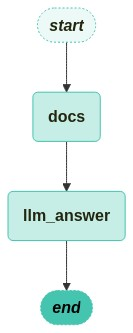

In [53]:
visualize_graph(graph)

- 질문 / 답변

In [56]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id" : "1"})   # 스레드 ID 설정

# --------------------첫 질문----------------------
question = "백업 후 복원하는 순서 알려줘"

for event in graph.stream(ChatbotState(question=question),config=config):
    print(event)

{'docs': {'documents': [Document(metadata={'page': 34, 'pdf_name': 'samsung.pdf', 'text': '백업 후 복원하기', 'type': 'heading1'}, page_content='# 백업 후 복원하기\n외부 저장 장치에 백업해 둔 데이터를 이용해 해당 백업 시점으로 제품을 복원할 수 있습니다.\n- 1 외부 저장 장치에 데이터를 백업해 둔 경우, 제품에 외부 저장 장치를 연결하세요.\n- 2 작업 표시줄에서 → 모든 앱 → Samsung → Samsung Recovery를 선택하세요.\n- 3 백업 관리를 누른 후 백업 이미지를 선택하고 복원을 선택하세요.\n- 4 복원을 누르세요.\n'), Document(metadata={'page': 44, 'pdf_name': 'samsung.pdf', 'text': '부팅 우선 순위 변경하기', 'type': 'heading1'}, page_content='# 부팅 우선 순위 변경하기\n'), Document(metadata={'page': 33, 'pdf_name': 'samsung.pdf', 'text': '초기 상태로 복원하기', 'type': 'heading1'}, page_content='# 초기 상태로 복원하기\n제품을 초기화하여 초기 상태로 복원할 수 있습니다.\n중요한 데이터가 있을 경우 복원 전에 중요한 데이터는 미리 백업해 두세요. 자세한 내용은 현재 시스템\n백업하기를 참고하세요.\n작업 표시줄에서 → 모든 앱 → Samsung → Samsung Recovery → 초기 이미지 → 복원 → 복원 →\n확인을 선택하세요.\n'), Document(metadata={'page': 33, 'pdf_name': 'samsung.pdf', 'text': '현재 시스템 백업하기', 'type': 'heading1'}, page_content='# 현재 시스템 백업하기\n- 1 제품에 외부 저장 장치를 연결하세요.\n- 2 작업 표시줄에서 → 